In [1]:
%matplotlib inline
%cd /home/wallar/projects/nyc-taxi-analysis/

/home/wallar/projects/nyc-taxi-analysis


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from scripts.plotting import plot_manhattan
from itertools import product
sns.set_context("paper", font_scale=2)

In [3]:
n_stations = 101

def load_data(p_st, d_st):
    fname = "data/ts/{}-{}.txt".format(p_st, d_st)
    df_options = {"names": ["datetime", "duration"],
                  "parse_dates": ["datetime"],
                  "infer_datetime_format": True,
                  "header": None,
                  #"squeeze": True,
                  "skip_blank_lines": True,
                  "index_col": 0}
    df = pd.read_csv(fname, **df_options)
    df.sort_index(inplace=True)
    return df


def load_all_ts():
    prod = product(xrange(n_stations), xrange(n_stations))
    rng = tqdm.tqdm_notebook(prod, total=n_stations ** 2)
    mat = np.zeros((n_stations, n_stations), dtype=pd.DataFrame)
    sizes = np.zeros((n_stations, n_stations))
    for i, j in rng:
        try:
            mat[i, j] = load_data(i, j)
            sizes[i, j] = len(mat[i, j])
        except IOError:
            pass
    return mat, sizes

In [4]:
mat, sizes = load_all_ts()
stations = pd.read_csv("data/stations.csv").as_matrix(["lng", "lat"])

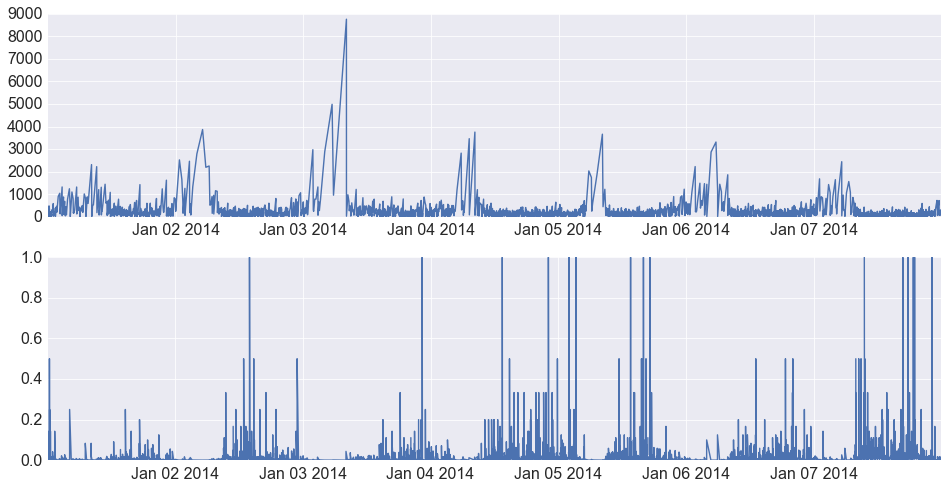

In [112]:
xs = mat[10, 21]["2014-01-01":"2014-01-07 23:59"].index
times = xs.astype(int) / (1000 * 1000000)

dts = np.zeros_like(times, dtype=np.float64)
for i in xrange(1, len(times)):
    dts[i] = (times[i] - times[i - 1])

fig, axs = plt.subplots(2, 1, figsize=(16, 8))
axs[0].plot(xs, dts)
axs[1].plot(xs, 1 / dts)

In [179]:
from scipy.stats import gamma
from math import exp, sqrt
from __future__ import division
    

xs = mat[10, 21]["2014-01-01":"2014-01-07 23:59"].index

def estimate_rate(xs):
    times = xs.astype(int) / (1000 * 1000000)

    dts = np.zeros_like(times, dtype=np.float64)
    for i in xrange(1, len(times)):
        dts[i] = (times[i] - times[i - 1])

    a, b = 440.008, 53328.0
    exps = np.zeros_like(dts)
    stds = np.zeros_like(dts)
    mles = np.zeros_like(dts)
    window_size = 30 * 60  # seconds
    alphas = [a]
    betas = [b]
    window = [times[0]]

    for i in xrange(exps.shape[0]): 
        a = sum(alphas) + 1
        b = sum(betas) + dts[i]
        alphas.append(1)
        betas.append(dts[i])
        window.append(times[i])
        exps[i] = a / b
        mles[i] = (a - 1) / b
        stds[i] = sqrt(a) / b
        to_delete = list()
        for j in xrange(len(window)):
            if times[i] - window[j] > window_size:
                to_delete.append(j)
        for j in reversed(to_delete):
            del window[j]
            del betas[j]
            del alphas[j]
    return gamma(a, scale=1 / b), exps

In [170]:
from collections import defaultdict
from gurobipy import *


def create_ilp(allowed_allocs, rates, caps, costs, max_region_time):
    m = Model("allocation")
    m.ModelSense = GRB.MINIMIZE
    vs = tuplelist()
    v_mat = np.zeros((len(caps), len(rates)), dtype=Var)
    ts = list()
    for d in xrange(len(caps)):
        for i in xrange(len(rates)):
            if allowed_allocs[d, i] == 1:
                name = "({},{})".format(d, i)
                v = m.addVar(vtype=GRB.BINARY, name=name)
                v_mat[d, i] = v
                vs.append((d, i, v))
            
    for i in xrange(len(rates)):
        name = "t_{}".format(i)
        t = m.addVar(lb=0, ub=max_region_time,
                     vtype=GRB.CONTINUOUS, name=name)
        ts.append(t)
        
    theta = m.addVar(vtype=GRB.CONTINUOUS, obj=1, name="theta")
            
    m.update()
    
    for i, r in enumerate(rates):
        sub_vs = vs.select("*", i, "*")
        lhs = quicksum([v * caps[d] for d, _, v in sub_vs])
        rhs = r * ts[i]
        m.addConstr(lhs <= rhs)
        
    # Every vehicle is assigned exactly once
    for d in xrange(len(caps)):
        sub_vs = vs.select(d, "*", "*")
        m.addConstr(quicksum([v for _, _, v in sub_vs]) == 1)
        
    for d in xrange(len(caps)):
        for i in xrange(len(rates)):
            m.addQConstr(v_mat[d, i] * (ts[i] + costs[d, i]) <= theta,
                         name="q_{}_{}".format(d, i))
        
    m.update()
        
    return m, v_mat, ts


def solve_ilp(m, v_mat, ts, allowed_allocs):
    m.optimize()
    allocs = defaultdict(list)
    times = dict()
    for d in xrange(v_mat.shape[0]):
        for i in xrange(v_mat.shape[1]):
            if allowed_allocs[d, i] == 1 and v_mat[d, i].x >= 0.0001:
                al_d, al_i = eval(v_mat[d, i].VarName)
                allocs[al_i].append(al_d)
                times[al_i] = ts[i].x
    return allocs, times

In [171]:
certainty = 0.95
rates = list()
n_regions = 10
n_ts = pow(n_regions, 2)
for i in xrange(n_regions):
    for j in xrange(n_regions):
        xs = mat[i, j]["2014-01-01":"2014-01-07 23:59"].index
        dist = estimate_rate(xs)
        #rates.append(dist.ppf(1 - certainty))
        rates.append(dist.mean())
        
allowed_allocs = np.random.randint(0, 2, size=(n_vecs, n_ts))
n_vecs = 40
max_region_time = 10000
caps = np.random.randint(1, 10, size=n_vecs)
costs = 1000 * np.random.rand(n_vecs, n_ts)
m, v_mat, ts = create_ilp(allowed_allocs, rates, caps, costs, max_region_time)
m.write("sandbox/allocation.mps")

In [172]:
allocs, durs = solve_ilp(m, v_mat, ts, allowed_allocs)
for route, vecs in allocs.iteritems():
    fmt = "Drive {} to {} for {:.2f} secs"
    print fmt.format(vecs, route, durs[route])

Optimize a model with 2112 rows, 2129 columns and 6128 nonzeros
Model has 2028 quadratic constraints
Coefficient statistics:
  Matrix range    [7e-05, 9e+00]
  Objective range [1e+00, 1e+00]
  Bounds range    [1e+00, 1e+04]
  RHS range       [1e+00, 1e+00]
Presolve removed 1975 rows and 792 columns
Presolve time: 0.05s
Presolved: 2615 rows, 2576 columns, 10009 nonzeros
Variable types: 773 continuous, 1803 integer (1239 binary)
Found heuristic solution: objective 10745.767833
Found heuristic solution: objective 10138.615148
Found heuristic solution: objective 10050.217659
Found heuristic solution: objective 9975.5131766

Root relaxation: objective 6.226391e+01, 833 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   62.26391    0  211 9975.51318   62.26391  99.4%     -    0s
H    0     0                    9657.5910465   62.26391  99.4%     -    0s


In [161]:
max(rates)

0.0079106561191251753

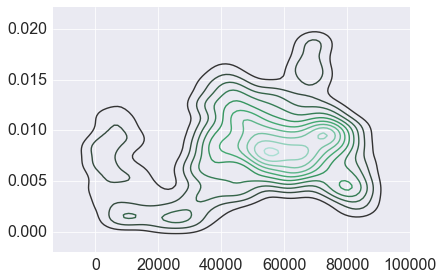

In [200]:
dist, rs = estimate_rate(xs)
sns.kdeplot(60 * 60 * xs.hour + 60 * xs.minute + xs.second, rs)

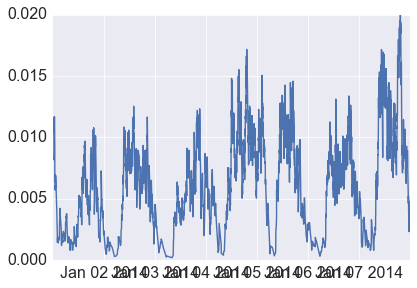

In [181]:
plt.plot(xs, rs)